In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from glob import glob
from tqdm import tqdm

/tmp/ipykernel_180178/2590474423.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def split_into_files(lines, num_files):
    # Calculate the number of lines per file
    lines_per_file = len(lines) // num_files
    remainder = len(lines) % num_files
    
    # Split lines into chunks for each file
    chunks = []
    start = 0
    for i in range(num_files):
        # Allocate the remainder evenly
        end = start + lines_per_file + (1 if i < remainder else 0)
        chunks.append(lines[start:end])
        start = end
    
    # Write each chunk to a separate file
    for i, chunk in enumerate(chunks):
        with open(f'sh{i+1}.sh', 'w') as f:
            f.write('\n'.join(chunk))

In [3]:
num_epoch = 2500
num_epoch_pretrain = 500
num_trials = 10
view_list = "1,2,3"
lr_e_pretrain = 1e-3
lr_e = 5e-4
lr_c = 1e-3
save_path = "results"

# Grid search

In [4]:
num_epoch = 2500
num_epoch_pretrain = 500
num_trials = 10
view_list = "1,2,3"
lr_e_pretrain = 1e-3
lr_e = 5e-4
lr_c = 1e-3
save_path = "results2"

commands = []
count = 0
for view_list in ["1", "2", "3", "1,2", "1,3", "2,3", "1,2,3"]:
    #for data_folder in ["BRCA", "ROSMAP", "KIPAN", "LGG"]:
    for data_folder in ["ROSMAP"]:
        for num_trials in range(2, 10, 1):
            for adj_param in range(2, 5, 1):
                command = f"python main_uncertainty.py --view_list={view_list} --data_folder={data_folder} --num_trials={num_trials}" \
                        f" --save_path={save_path} --num_epoch={num_epoch}  --num_epoch_pretrain={num_epoch_pretrain}" \
                        f" --lr_e={lr_e} --lr_c={lr_c} --exp=exp --num_adj={adj_param}"
                # print(command)
                count += 1
                commands.append(command)
print(count)

split_into_files(commands, 2)

168


In [5]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

df_performance = pd.DataFrame(columns=['data_folder', 'view_list', 'num_trials', 'adj_param', 'acc','measure1','measure2','uncertainty'])
#for data_folder in ["BRCA", "ROSMAP", "LGG", "KIPAN"]:
data_folder = "ROSMAP"

for view_list in ["1", "2", "3", "1,2", "1,3", "2,3", "1,2,3"]:
    for num_trials in range(2, 16, 2):
            for adj_param in [2, 4, 6, 8, 10]:
                df = pd.read_csv(f"{save_path}/{data_folder}/{view_list}/n_trials{num_trials}_adj{adj_param}.csv")
                pred = df['pred'].to_numpy()
                label = df['label'].to_numpy()
                uncertainty = np.mean(df['std'].to_numpy())
                if data_folder in ['ROSMAP', 'LGG']:
                    acc = accuracy_score(label, pred)
                    measure1 = f1_score(label, pred)
                    measure2 = roc_auc_score(label, pred)
                
                if data_folder in ['BRCA', 'KIPAN']:
                    acc = accuracy_score(label, pred)
                    measure1 = f1_score(label, pred, average='weighted')
                    measure2 = f1_score(label, pred, average='macro')

                df_performance.loc[df_performance.shape[0]] = pd.Series({"data_folder": data_folder, "view_list": view_list.replace(",","-"), 
                                                                "acc": acc, "measure1": measure1, "measure2": measure2, "uncertainty": uncertainty, 
                                                                "num_trials": num_trials, "adj_param": adj_param})
df_performance.to_csv(f"{save_path}/performance.csv", index=False)
df_performance.head(5)

,data_folder,view_list,num_trials,adj_param,acc,measure1,measure2,uncertainty
0,ROSMAP,1,2,2,0.792453,0.810345,0.790018,0.038906
1,ROSMAP,1,2,4,0.792453,0.792453,0.793583,0.035834
2,ROSMAP,1,2,6,0.783019,0.762887,0.787344,0.039105
3,ROSMAP,1,2,8,0.773585,0.75,0.778253,0.027454
4,ROSMAP,1,2,10,0.754717,0.754717,0.755793,0.023178


# Visualize performance

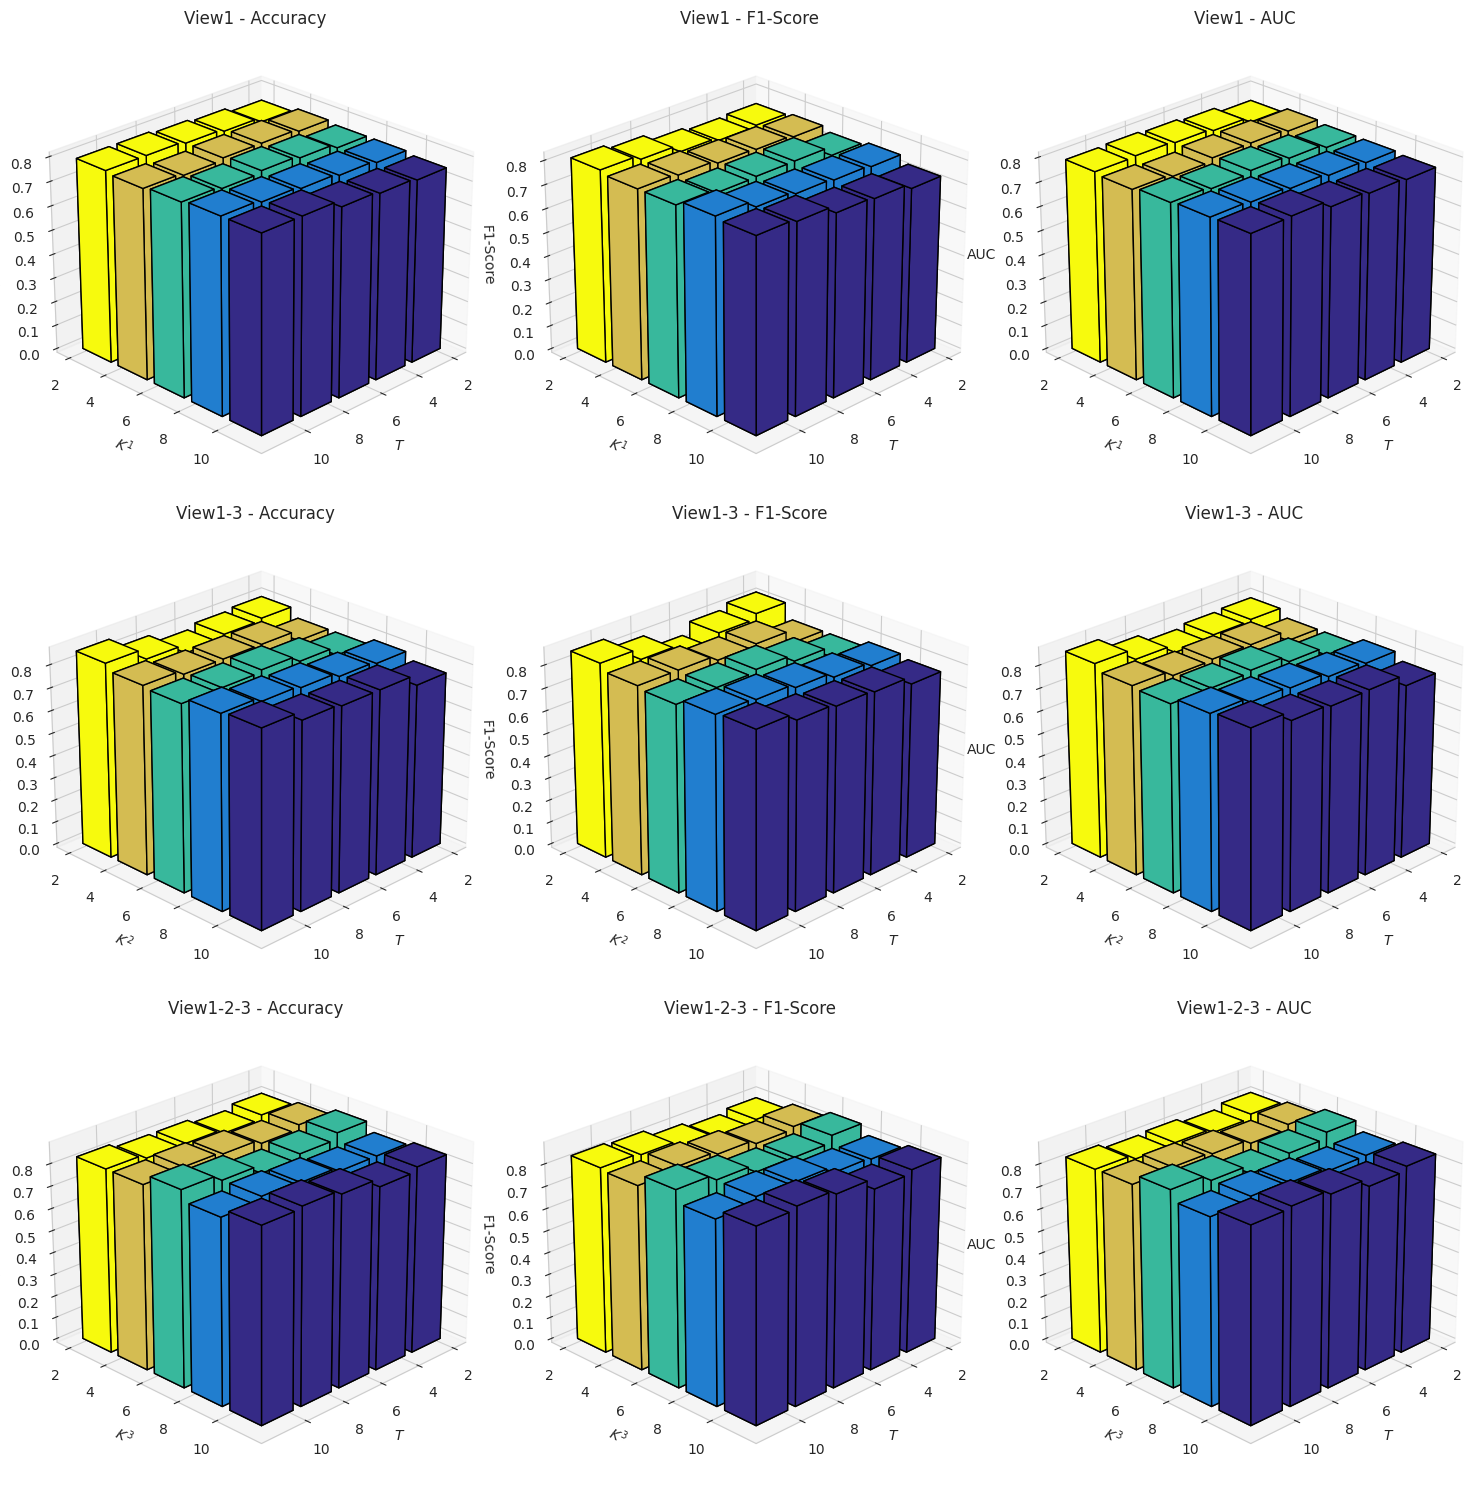

In [43]:
# Filter the dataframe to include only desired view_list values
df_performance_sub = df_performance[df_performance['num_trials'].isin([2,4,6,8,10])]
view_lists = ["1", "1-3", "1-2-3"]  # Desired view_list categories

fig = plt.figure(figsize=(15, 15))  # Set a larger figure size to accommodate a 3x3 grid

# Define metrics and labels
metrics = ['acc', 'measure1', 'measure2']
titles = [r"Accuracy", r"F1-Score", r"AUC"]

# Loop through each view_list category and metric to create the subplots
for row_idx, view in enumerate(view_lists):
    # Filter the data for the current view_list category
    df_view = df_performance_sub[df_performance_sub['view_list'] == view]
    
    for col_idx, metric in enumerate(metrics):
        ax = fig.add_subplot(3, 3, row_idx * 3 + col_idx + 1, projection='3d')

        # Get unique counts for x and y axis labels
        n_x = len(np.unique(df_view['num_trials']))
        n_y = len(np.unique(df_view['adj_param']))

        # Color map for bars
        colors = ["#352A86", "#217ECF", "#38B89C", "#D4BC52", "#F7FA0D"][::-1]

        # Plot each y group
        for idx_y in range(n_y):
            xpos = np.arange(n_x)
            ypos = np.zeros(n_x) + idx_y
            zpos = np.zeros(n_x)
            dx = np.ones(n_x) * 0.8
            dy = np.ones(n_x) * 0.8
            
            # Filter data for the current group and metric
            sub_df = df_view[df_view['num_trials'] == np.unique(df_view['adj_param'])[idx_y]][::-1]
            dz = sub_df[metric].to_list()

            ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors[idx_y], alpha=1, shade=False, edgecolor="black")

        # Set view angle and axis labels for each subplot
        ax.view_init(25, 45)
        ax.set_xlabel(r"$T$")
        ax.set_xticks(np.arange(n_x))
        ax.set_xticklabels(np.unique(df_view['num_trials']))
        
        ax.set_ylabel(rf"$K^{row_idx+1}$")
        ax.set_yticks(np.arange(n_y))
        ax.set_yticklabels(np.unique(df_view['adj_param']))
        
        ax.set_zlabel(titles[col_idx])
        ax.set_title(f"View{view} - {titles[col_idx]}")

# Adjust layout for better spacing
plt.savefig(f"{save_path}/hyperparam_settings.png", dpi=300)
fig.tight_layout()
plt.show()


# Select best and perform staged prediction

In [31]:
result_df = pd.DataFrame(columns=['data_folder', 'view_list', 'num_trials', 'adj_param', 'acc','measure1','measure2','uncertainty'])
for dataset in ["ROSMAP"]:
    df_performance_sub = df_performance[df_performance['data_folder']==dataset]
    for view_list in ["1","2","3"]:
        single_modality_df = df_performance_sub[df_performance_sub['view_list'].apply(lambda x: '-' not in x)]
        single_modality_df = single_modality_df[single_modality_df['view_list']==view_list]
        best_single_modality = single_modality_df.loc[single_modality_df['acc'].idxmax()]
        result_df = pd.concat([result_df, best_single_modality.to_frame().T])

    for view_list in ["1-2", "1-3", "2-3"]:
        two_modality_df = df_performance_sub[df_performance_sub['view_list'].apply(lambda x: '-' in x and len(x.split('-')) == 2)]
        two_modality_df = two_modality_df[two_modality_df['view_list']==view_list]
        best_two_modality = two_modality_df.loc[two_modality_df['acc'].idxmax()]
        result_df = pd.concat([result_df, best_two_modality.to_frame().T])

    # Step 3: Keep the row with the view list of 1-2-3 if it exists
    three_modality_df = df_performance_sub[df_performance_sub['view_list'] == '1-2-3']
    best_modality_df = three_modality_df.loc[three_modality_df['acc'].idxmax()]

    # Combine all selected rows into a new dataframe
    result_df = pd.concat([result_df, best_modality_df.to_frame().T])

result_df.to_csv(f"{save_path}/best_performance_for_each_view.csv", index=False)
result_df

,data_folder,view_list,num_trials,adj_param,acc,measure1,measure2,uncertainty
25,ROSMAP,1,12,2,0.811321,0.818182,0.811052,0.084549
54,ROSMAP,2,8,10,0.669811,0.646465,0.673262,0.051066
79,ROSMAP,3,4,10,0.726415,0.738739,0.725668,0.048816
106,ROSMAP,1-2,2,4,0.839623,0.828283,0.843316,0.047709
140,ROSMAP,1-3,2,2,0.858491,0.859813,0.859358,0.136871
195,ROSMAP,2-3,10,2,0.754717,0.75,0.756506,0.151831
220,ROSMAP,1-2-3,6,2,0.877358,0.878505,0.878253,0.11357


# staged

In [32]:
result_df = pd.DataFrame(columns=['data_folder', 'view_list', 'num_trials', 'adj_param', 'acc','measure1','measure2','uncertainty'])
for dataset in ["ROSMAP"]:
    df_performance_sub = df_performance[df_performance['data_folder']==dataset]
    single_modality_df = df_performance_sub[df_performance_sub['view_list'].apply(lambda x: '-' not in x)]
    best_single_modality = single_modality_df.loc[single_modality_df['acc'].idxmax()]

    # Step 2: Select the best two-modality view containing the best single modality
    best_single_view = best_single_modality['view_list']
    two_modality_df = df_performance_sub[df_performance_sub['view_list'].apply(lambda x: '-' in x and len(x.split('-')) == 2 and best_single_view in x)]
    best_two_modality = two_modality_df.loc[two_modality_df['acc'].idxmax()]

    # Step 3: Keep the row with the view list of 1-2-3 if it exists
    three_modality_df = df_performance_sub[df_performance_sub['view_list'] == '1-2-3']
    best_modality_df = three_modality_df.loc[three_modality_df['acc'].idxmax()]

    # Combine all selected rows into a new dataframe
    result_df_sub = pd.concat([best_single_modality.to_frame().T, best_two_modality.to_frame().T, best_modality_df.to_frame().T])
    result_df = pd.concat([result_df_sub, result_df])

result_df.to_csv(f"{save_path}/best_performance_for_stage.csv", index=False)
result_df

,data_folder,view_list,num_trials,adj_param,acc,measure1,measure2,uncertainty
25,ROSMAP,1,12,2,0.811321,0.818182,0.811052,0.084549
140,ROSMAP,1-3,2,2,0.858491,0.859813,0.859358,0.136871
220,ROSMAP,1-2-3,6,2,0.877358,0.878505,0.878253,0.11357


In [9]:
view_lists = result_df[result_df['data_folder']==data_folder]['view_list'].to_list()
num_trails = result_df[result_df['data_folder']==data_folder]['num_trials'].to_list() 
adj_param = result_df[result_df['data_folder']==data_folder]['adj_param'].to_list()

converted_view_list = [view.replace('-', ',') for view in view_lists]
print(converted_view_list)
print(num_trails)
print(adj_param)

['1', '1,3', '1,2,3']
[12, 2, 6]
[2, 2, 2]


In [10]:
df_staged = pd.DataFrame(columns=["data_folder", "acc",  'num_trials', 'adj_param', "measure1", "measure2", "t1", "t2"])

#for data_folder in ["ROSMAP", "BRCA", "LGG", "KIPAN"]:
for data_folder in ["ROSMAP"]:
    view_lists = result_df[result_df['data_folder']==data_folder]['view_list'].to_list()
    converted_view_list = [view.replace('-', ',') for view in view_lists]
    num_trails = result_df[result_df['data_folder']==data_folder]['num_trials'].to_list() 
    adj_param = result_df[result_df['data_folder']==data_folder]['adj_param'].to_list()

    df_uni = pd.read_csv(f"{save_path}/{data_folder}/{converted_view_list[0]}/n_trials{num_trails[0]}_adj{adj_param[0]}.csv").copy()
    df_bi = pd.read_csv(f"{save_path}/{data_folder}/{converted_view_list[1]}/n_trials{num_trails[1]}_adj{adj_param[1]}.csv").copy()
    df_tri = pd.read_csv(f"{save_path}/{data_folder}/{converted_view_list[2]}/n_trials{num_trails[2]}_adj{adj_param[2]}.csv").copy()
    threshold_range_uni = np.linspace(df_uni['std'].min(), df_uni['std'].max(), 50)
    threshold_range_bi = np.linspace(df_bi['std'].min(), df_bi['std'].max(), 50)

    best_auc = 0.
    best_threshold_t1 = 0
    best_threshold_t2 = 0

    for t1 in tqdm(threshold_range_uni):
        for t2 in threshold_range_bi:
            df_classified_confident_stage = pd.DataFrame(columns=["patient_id", "stage", "std", "pred", "label"])
            move_forward = True

            # single view
            df_uni['confident'] = df_uni['std'] <= t1
            df_uni_confident = df_uni[df_uni['confident']]
            df_uni_confident = df_uni_confident.copy()
            df_uni_confident.loc[:, "stage"] = view_lists[0]

            df_uni_confident = df_uni_confident[["patient_id", "stage", "std", "pred", "label"]]
            df_classified_confident_stage = pd.concat([df_classified_confident_stage, df_uni_confident], ignore_index=True)

            if df_classified_confident_stage.shape[0] != df_uni.shape[0]:
                # Unconfident predictions - use 2 views
                df_uni_unconfident = df_uni[~df_uni['confident']]
                df_bi_sub = df_bi[df_bi['patient_id'].isin(df_uni_unconfident['patient_id'])]
                df_bi_sub = df_bi_sub.copy()
                df_bi_sub.loc[:, 'confident'] = df_bi_sub['std'] <= t2
                df_bi_confident = df_bi_sub[df_bi_sub['confident']]
                
                if df_bi_confident.shape[0] == 0:
                    # t2 is too small, no subjects in bi-view model is confident
                    continue
                
                df_bi_confident = df_bi_confident.copy()
                df_bi_confident.loc[:, "stage"] = view_lists[1]
                df_bi_confident = df_bi_confident[["patient_id", "stage", "std", "pred", "label"]]
                df_classified_confident_stage = pd.concat([df_classified_confident_stage, df_bi_confident], ignore_index=True)

                if df_classified_confident_stage.shape[0] != df_uni.shape[0]:
                    # Unconfident predictions - use 3 views
                    df_bi_unconfident = df_bi_sub[~df_bi_sub['confident']]
                    df_tri_sub = df_tri[df_tri['patient_id'].isin(df_bi_unconfident['patient_id'])]
                    df_tri_sub = df_tri_sub.copy()
                    df_tri_sub.loc[:, 'stage'] = view_lists[2]
                    df_tri_sub = df_tri_sub[["patient_id", "stage", "std", "pred", "label"]]
                    df_classified_confident_stage = pd.concat([df_classified_confident_stage, df_tri_sub], ignore_index=True)

            assert df_classified_confident_stage.shape[0] == df_uni.shape[0]
            total_accuracy = accuracy_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list())
            total_f1 = f1_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list())
            total_auc = roc_auc_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list())
            # Update best threshold if this one is better
            if total_auc > best_auc:
                best_auc = total_auc
                best_threshold_t1 = t1
                best_threshold_t2 = t2
                df_classified_confident_stage.to_csv(f"{save_path}/{data_folder}/staged_results.csv", index=False)
            # print(f"acc = {total_accuracy}, t1 = {t1}, t2 = {t2}")

    if data_folder in ["ROSMAP", "LGG"]:
        acc = accuracy_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list())
        measure1 = f1_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list())
        measure2 = roc_auc_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list())
    elif data_folder in ["KIPAN", "BRCA"]:
        acc = accuracy_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list())
        measure1 = f1_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list(), average='weighted')
        measure2 = f1_score(df_classified_confident_stage['label'].to_list(), df_classified_confident_stage['pred'].to_list(), average='macro')
    print(f"data_folder = {data_folder}, best_accuracy = {acc}, measure1 = {measure1}, measure2 = {measure2}, best_threshold_t1 = {best_threshold_t1}, best_threshold_t2 = {best_threshold_t2}")
    
    df_staged.loc[df_staged.shape[0]] = pd.Series({"data_folder": data_folder, "acc": acc, "measure1": measure1, "measure2": measure2, 
                                                    "t1": best_threshold_t1, "t2": best_threshold_t2})
df_staged.to_csv(f"{save_path}/staged_performance.csv", index=False)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:07<00:00,  6.89it/s]

data_folder = ROSMAP, best_accuracy = 0.8113207547169812, measure1 = 0.8181818181818182, measure2 = 0.8110516934046347, best_threshold_t1 = 0.0, best_threshold_t2 = 0.10737559996326529


# Staged percentage

In [33]:
df_staged_percent = pd.DataFrame(columns=["data_folder", "stage1", "stage2", "stage3"])
#for data_folder in ["ROSMAP", "BRCA", "LGG", "KIPAN"]:
for data_folder in ["ROSMAP"]:
    df_classified_confident_stage = pd.read_csv(f"{save_path}/{data_folder}/staged_results.csv")
    n_subjects = df_classified_confident_stage.shape[0]
    stages = pd.unique(df_classified_confident_stage['stage'])
    stage_strings = []
    for stage in stages:
        stage_string = ""
        if stage.rfind("1")!=-1:
            stage_string += "mRNA|"
        if stage.rfind("2")!=-1:
            stage_string += "methy|"
        if stage.rfind("3")!=-1:
            stage_string += "miRNA|"
        stage_string += f"{df_classified_confident_stage[df_classified_confident_stage['stage']==stage].shape[0]/n_subjects *100 : 0.2f}%"
        stage_strings.append(stage_string)
    df_staged_percent.loc[df_staged_percent.shape[0]] = pd.Series({"data_folder": data_folder, "stage1": stage_strings[0] , "stage2": stage_strings[1] , "stage3": stage_strings[2]})

df_staged_percent.to_csv(f"{save_path}/percentage.csv", index=False)
df_staged_percent

,data_folder,stage1,stage2,stage3
0,ROSMAP,mRNA| 0.94%,mRNA|miRNA| 33.96%,mRNA|methy|miRNA| 65.09%


# Uncertainty distribution

/tmp/ipykernel_180178/3919111615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classified_confident_stage_sub['label_c'] = df_classified_confident_stage_sub['label'].map(label_map)
/tmp/ipykernel_180178/3919111615.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_classified_confident_stage_sub, x="std", hue="label_c", ax=axes[i], palette="tab10")
/tmp/ipykernel_180178/3919111615.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

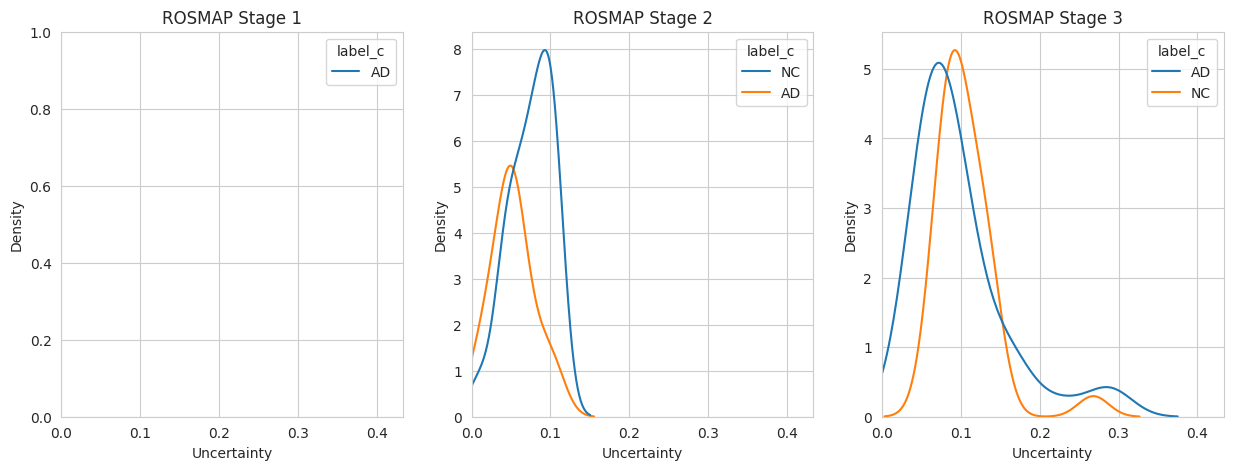

In [38]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(5)
sns.set_style("whitegrid")


label_map = {0: 'NC', 1: 'AD'}

#for idx, data_folder in enumerate(["ROSMAP", "LGG", "BRCA", "KIPAN"]):
for idx, data_folder in enumerate(["ROSMAP"]):
    view_lists = result_df[result_df['data_folder']==data_folder]['view_list'].to_list()
    converted_view_list = [view.replace('-', ',') for view in view_lists]

    df_classified_confident_stage = pd.read_csv(f"{save_path}/{data_folder}/staged_results.csv")
    for i in range(3):
        df_classified_confident_stage_sub = df_classified_confident_stage[df_classified_confident_stage['stage']==view_lists[i]]
        df_classified_confident_stage_sub['label_c'] = df_classified_confident_stage_sub['label'].map(label_map)
        sns.kdeplot(df_classified_confident_stage_sub, x="std", hue="label_c", ax=axes[i], palette="tab10")
        axes[i].set_title(f"{data_folder} Stage {i+1}")
        axes[i].set_xlim(0,np.max(df_classified_confident_stage['std'])*1.5)
        axes[i].set_xlabel("Uncertainty")

plt.savefig(f"{save_path}/uncertainty_distribution.png", dpi=300)
plt.show()


# Explain Features

In [13]:
result_df

,data_folder,view_list,num_trials,adj_param,acc,measure1,measure2,uncertainty
25,ROSMAP,1,12,2,0.811321,0.818182,0.811052,0.084549
140,ROSMAP,1-3,2,2,0.858491,0.859813,0.859358,0.136871
220,ROSMAP,1-2-3,6,2,0.877358,0.878505,0.878253,0.11357


In [39]:
import copy
from feat_importance import cal_feat_imp, summarize_imp_feat

data_folder = 'ROSMAP'
exp_path = "exp"
num_class = 2

print(converted_view_list)

df_featimp_top_list = []
for stage in range(3):
    view_list, num_trails, adj_parameter = result_df.iloc[stage]['view_list'], result_df.iloc[stage]['num_trials'], result_df.iloc[stage]['adj_param']
    str_view_list = view_list.replace('-', ',')
    view_list = [int(x) for x in str_view_list.split(',')] 
    #print(view_list)
    
    for t in range(num_trails):
        featimp_list_list = []
        featimp_list = cal_feat_imp(data_folder, f"{exp_path}/{data_folder}_v{str_view_list}_t{num_trails}_a{adj_parameter}/trail{t}", view_list, num_class, adj_parameter)
        featimp_list_list.append(copy.deepcopy(featimp_list))

    feat_names, df_featimp_top = summarize_imp_feat(featimp_list_list, topn=30)
    df_featimp_top['omics_s'] = df_featimp_top['omics'].map({0: "mRNA", 1: "DNAmethy", 2: "miRNA"})
    df_featimp_top['imp'] = df_featimp_top['imp']/num_trails
    df_featimp_top.to_csv(f"{save_path}/feat_imp_{str_view_list}.csv", index=False)
    df_featimp_top_list.append(df_featimp_top)


['1', '1,3', '1,2,3']
Rank	Feature name
1	ENSG00000117266.11	89.91784914115011
2	ENSG00000105643.3	79.81451963483553
3	ENSG00000155980.6	79.81451963483553
4	ENSG00000171388.9	76.09399183903194
5	ENSG00000168743.8	61.31546560918911
6	ENSG00000204219.5	55.456310679611654
7	ENSG00000119950.15	50.122977346278304
8	ENSG00000065809.8	48.75360797690895
9	ENSG00000142765.12	46.19315278487481
10	ENSG00000242349.1	45.12719675556103
11	ENSG00000143772.5	43.76400298730396
12	ENSG00000182310.7	42.36540158870257
13	ENSG00000020577.9	41.45631067961164
14	ENSG00000091513.10	41.45631067961164
15	ENSG00000254211.1	40.612937185635744
16	ENSG00000011426.6	40.06390561632052
17	ENSG00000235501.1	40.06390561632052
18	ENSG00000099194.4	38.63579785909883
19	ENSG00000053702.10	37.87606376603141
20	ENSG00000102032.8	37.87606376603141
21	ENSG00000116786.7	37.17059639389737
22	ENSG00000160285.9	34.38313994790434
23	ENSG00000166508.13	32.937792161093135
24	ENSG00000198624.8	32.4086916319926
25	ENSG00000139352.3	27.

In [26]:
# Stage 1,2,3
common_feat_names = pd.merge(df_featimp_top_list[0][['feat_name']], df_featimp_top_list[1][['feat_name']], on='feat_name')
common_feat_names = pd.merge(common_feat_names, df_featimp_top_list[2][['feat_name']], on='feat_name')
common_feat_names


,feat_name
0,ENSG00000117266.11
1,ENSG00000105643.3
2,ENSG00000155980.6
3,ENSG00000171388.9
4,ENSG00000168743.8
5,ENSG00000204219.5
6,ENSG00000065809.8
7,ENSG00000142765.12
8,ENSG00000182310.7
9,ENSG00000020577.9


In [27]:
common_feat_names = pd.merge(df_featimp_top_list[1][['feat_name']], df_featimp_top_list[2][['feat_name']], on='feat_name')
common_feat_names

,feat_name
0,ENSG00000117266.11
1,ENSG00000155980.6
2,ENSG00000099194.4
3,ENSG00000105643.3
4,ENSG00000168743.8
5,ENSG00000182310.7
6,ENSG00000020577.9
7,ENSG00000171388.9
8,ENSG00000116786.7
9,ENSG00000142765.12


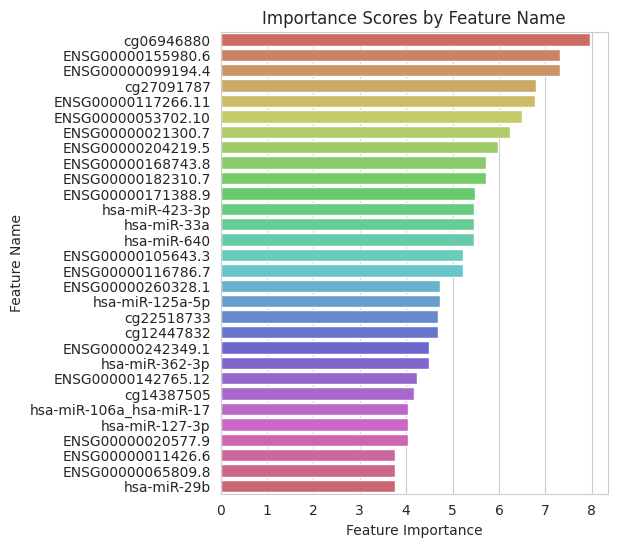

In [49]:
plt.figure(figsize=(5, 6))
sns.barplot(data=df_featimp_top_list[2], y='feat_name', x='imp', palette="hls")

# Labels and title
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Importance Scores by Feature Name")


plt.savefig(f"{save_path}/feat_img_vis.png", dpi=300)

plt.show()